In [15]:
from sklearn.datasets import load_breast_cancer

In [16]:
df = load_breast_cancer(as_frame=True)

In [17]:
X = df.data
y = df.target

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import GridSearchCV

In [19]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

In [20]:
knn_grid = {
    "knn__n_neighbors": np.arange(1,31,2)
}

In [21]:
knn = GridSearchCV(
    knn_pipe,
    knn_grid,
    cv = 5,
    n_jobs = -1
)

In [22]:
lr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(max_iter=200_000))
])

In [26]:
lr_grid = {
    "lr__C":np.logspace(-3, 3, 50)
}

In [27]:
lr = GridSearchCV(
    lr_pipe,
    lr_grid,
    cv = 5,
    n_jobs = -1
)

In [60]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

In [87]:
def cv5_report(name, model, X, y, outer_splits=5):

    skf = StratifiedKFold(n_splits = outer_splits, random_state = 42, shuffle = True)

    folds = []
    aucs = []

    plt.figure(figsize=(6,5))
    for fold, (train_index, test_index) in enumerate(skf.split(X,y),1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        if hasattr(model, "best_estimator_"):
            best_model = model.best_estimator_
        else:
            best_model = model

        y_test_pred = best_model.predict(X_test)
        y_test_prob = best_model.predict_proba(X_test)[:,1]
        
        #Test Metrics
        acc = accuracy_score(y_test, y_test_pred)
        pre = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)

        #ROC_curve
        fpr, tpr, _ = roc_curve(y_test, y_test_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"{name} ROC Curve")
        plt.grid()
        plt.legend()
        
        
        aucs.append(roc_auc)
        
        folds.append(
            {"Model":name, "Fold":fold, "Accuracy":acc, "Precision":pre,
            "Recall":rec, "F1":f1, "AUC": roc_auc}
        )
        
    plt.show()
    
    folds_df = pd.DataFrame(folds)

    row_mean = {
            "Model":name,
            "Fold":"Mean",
            "Accuracy":folds_df["Accuracy"].mean(),
            "Precision":folds_df["Precision"].mean(),
            "Recall":folds_df["Recall"].mean(),
            "F1":folds_df["F1"].mean(),
            "AUC":folds_df["AUC"].mean(),
    }

    results = pd.concat([folds_df, pd.DataFrame([row_mean])])
    
    return results 

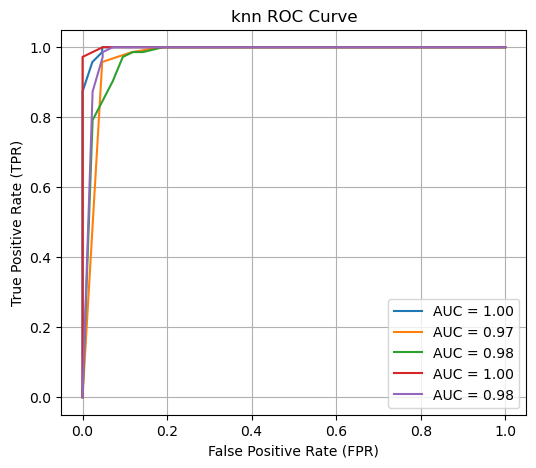

,Model,Fold,Accuracy,Precision,Recall,F1,AUC
0,knn,1,0.982456,0.972603,1.000000,0.986111,0.997380
1,knn,2,0.947368,0.933333,0.985915,0.958904,0.973305
2,knn,3,0.947368,0.934211,0.986111,0.959459,0.975694
3,knn,4,0.982456,1.000000,0.972222,0.985915,0.999339
4,knn,5,0.973451,0.959459,1.000000,0.979310,0.984574
0,knn,Mean,0.966620,0.959921,0.988850,0.973940,0.986058


In [88]:
cv5_report("knn", knn, X, y, 5)